# Tarea 2 - Sistema de recomendación
## Inteligencia de negocios

### Bibliotecas usadas

In [1]:
import pandas as pd
from dotenv import load_dotenv
import requests
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (12,10)

load_dotenv()

True

### Carga de datos y preprocesamiento

#### Lectura de los archivos

In [2]:
movie_titles = pd.read_csv("movie_titles.csv", usecols=range(3), names=['id', 'year', 'name'], encoding='ISO-8859-1')
movie_titles

,id,year,name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


In [3]:

ratings_folder = 'c:\\umayor\\training_set'
files = ['\\mv_{}.txt'.format(str(f).zfill(7)) for f in range(1,17771)]
movie_ratings = pd.DataFrame(columns = ['movie', 'user', 'rating', 'date'])
df_list = []

for filename in tqdm(files):
    temp = pd.read_csv(ratings_folder + filename, names = ['user', 'rating', 'date'], skiprows = 1)
    temp['movie'] = filename.split('.')[0].split('_')[1].lstrip('0')
    df_list.append(temp)

movie_ratings = pd.concat(df_list).loc[:, ['movie', 'user', 'rating', 'date']]
movie_ratings = movie_ratings.astype({'movie': np.int32, 'user': np.int32, 'rating': np.int32})
movie_ratings


100%|██████████| 17770/17770 [00:52<00:00, 341.43it/s]


,movie,user,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03
...,...,...,...,...
916,17770,1790158,4,2005-11-01
917,17770,1608708,3,2005-07-19
918,17770,234275,1,2004-08-07
919,17770,255278,4,2004-05-28


#### Identificación y corrección de columnas vacías

In [4]:
print("----- Campos NaN en columna id -----\n", movie_titles[movie_titles['name'].isna()])
print("----- Campos NaN en columna año -----\n", movie_titles[movie_titles['year'].isna()])
print("----- Campos NaN en columna nombre -----\n", movie_titles[movie_titles['id'].isna()])

----- Campos NaN en columna id -----
 Empty DataFrame
Columns: [id, year, name]
Index: []
----- Campos NaN en columna año -----
           id  year                                         name
4387    4388   NaN      Ancient Civilizations: Rome and Pompeii
4793    4794   NaN  Ancient Civilizations: Land of the Pharaohs
7240    7241   NaN     Ancient Civilizations: Athens and Greece
10781  10782   NaN                       Roti Kapada Aur Makaan
15917  15918   NaN                      Hote Hote Pyaar Ho Gaya
16677  16678   NaN                              Jimmy Hollywood
17666  17667   NaN                           Eros Dance Dhamaka
----- Campos NaN en columna nombre -----
 Empty DataFrame
Columns: [id, year, name]
Index: []


#### Llenado de la información faltante
Para no tener que eliminar estas películas, primero probamos la API de The Movie Database, en caso de que esta pudiera entregarnos los años de cada película.

In [5]:
api_key = os.getenv("API_KEY")

for movie in movie_titles[movie_titles['year'].isna()]['name']:
    url = f"https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={movie}"
    response = requests.get(url)
    data = response.json()
    try:
        relase_date = data['results'][0]['release_date']
        if relase_date == '':
            raise
        release_year = relase_date[:4]
        print("🟢 La fecha de lanzamiento de " + movie + " es " + relase_date + ", del año " + release_year + ".")
        movie_titles.loc[movie_titles['name'] == movie, 'year'] = release_year
    except: print("🔴 No se encontró fecha de lanzamiento para " + movie + ".")

🔴 No se encontró fecha de lanzamiento para Ancient Civilizations: Rome and Pompeii.
🔴 No se encontró fecha de lanzamiento para Ancient Civilizations: Land of the Pharaohs.
🔴 No se encontró fecha de lanzamiento para Ancient Civilizations: Athens and Greece.
🟢 La fecha de lanzamiento de Roti Kapada Aur Makaan es 1974-01-01, del año 1974.
🔴 No se encontró fecha de lanzamiento para Hote Hote Pyaar Ho Gaya.
🟢 La fecha de lanzamiento de Jimmy Hollywood es 1994-03-30, del año 1994.
🔴 No se encontró fecha de lanzamiento para Eros Dance Dhamaka.


Ya que solo se encontró el año de lanzamiento de dos películas, se procede a hacer una búsqueda manual en Google para llenar las películas faltantes.

In [6]:
movie_titles.at[4387, 'year'] = 2001
movie_titles.at[4793, 'year'] = 2001
movie_titles.at[7240, 'year'] = 2002
movie_titles.at[15917, 'year'] = 1999
movie_titles.at[17666, 'year'] = 1999
movie_titles = movie_titles.astype(dtype = {'id': np.int32, 'year': np.int32})
print("----- Campos NaN en columna año -----\n", movie_titles[movie_titles['year'].isna()])

----- Campos NaN en columna año -----
 Empty DataFrame
Columns: [id, year, name]
Index: []


## Análisis

In [7]:
movie_titles.describe()

,id,year
count,17770.000000,17770.000000
mean,8885.500000,1990.265841
std,5129.901477,16.506002
min,1.000000,1896.000000
25%,4443.250000,1985.000000
50%,8885.500000,1997.000000
75%,13327.750000,2002.000000
max,17770.000000,2005.000000


In [8]:
movie_ratings['rating'].describe()

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [307]:
movie_ratings

,movie,user,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03
...,...,...,...,...
916,17770,1790158,4,2005-11-01
917,17770,1608708,3,2005-07-19
918,17770,234275,1,2004-08-07
919,17770,255278,4,2004-05-28


In [324]:
#pivot_matrix = movie_ratings.pivot(index='movie', columns='user', values='rating').fillna(0)
movie_ratings_groups = movie_ratings.groupby(['user'])

In [280]:
movie_ratings[movie_ratings.movie == 1]['rating'].mean()

3.749542961608775

In [282]:
movie_ratings.loc[movie_ratings['movie'] == 1, 'movie']

0      1
1      1
2      1
3      1
4      1
      ..
542    1
543    1
544    1
545    1
546    1
Name: movie, Length: 547, dtype: int32

In [57]:
mean_ratings = movie_ratings.groupby('movie')['rating'].agg(['mean','count'])
mean_ratings

,mean,count
movie,,
1,3.749543,547
2,3.558621,145
3,3.641153,2012
4,2.739437,142
5,3.919298,1140
...,...,...
17766,3.193388,605
17767,3.671569,204
17768,2.839207,1362


In [137]:
mean_ratings.sort_values(by='mean', ascending=False).head(10)

,mean,count
movie,,
14961,4.723270,73335
7230,4.716611,73422
7057,4.702611,74912
3456,4.670989,7249
9864,4.638809,1747
15538,4.605021,1633
8964,4.600000,25
14791,4.600000,75
10464,4.595506,89


In [113]:
mean_ratings.sort_values(by=['count'], ascending=False).head(10)['mean']

Int64Index([5317, 15124, 14313, 15205, 1905, 6287, 11283, 16377, 16242, 12470], dtype='int64', name='movie')

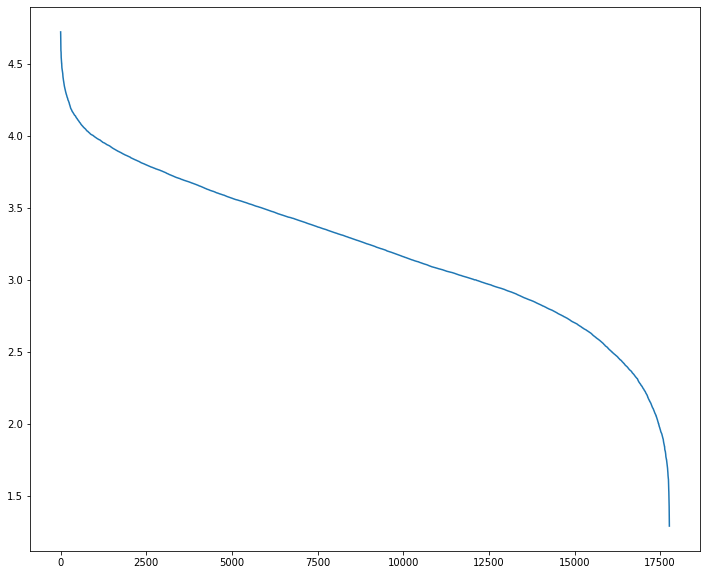

In [199]:
plt.plot(mean_ratings.sort_values(by='mean', ascending=False)['mean'].values)

(array([   7.,   13.,   35.,   84.,  148.,  207.,  287.,  425.,  586.,
         714., 1026., 1335., 1824., 1654., 1677., 1726., 1676., 1446.,
        1261.,  875.,  433.,  189.,   85.,   45.,   12.]),
 array([1.28787879, 1.42529443, 1.56271008, 1.70012572, 1.83754137,
        1.97495702, 2.11237266, 2.24978831, 2.38720395, 2.5246196 ,
        2.66203524, 2.79945089, 2.93686653, 3.07428218, 3.21169783,
        3.34911347, 3.48652912, 3.62394476, 3.76136041, 3.89877605,
        4.0361917 , 4.17360734, 4.31102299, 4.44843863, 4.58585428,
        4.72326993]),
 <BarContainer object of 25 artists>)

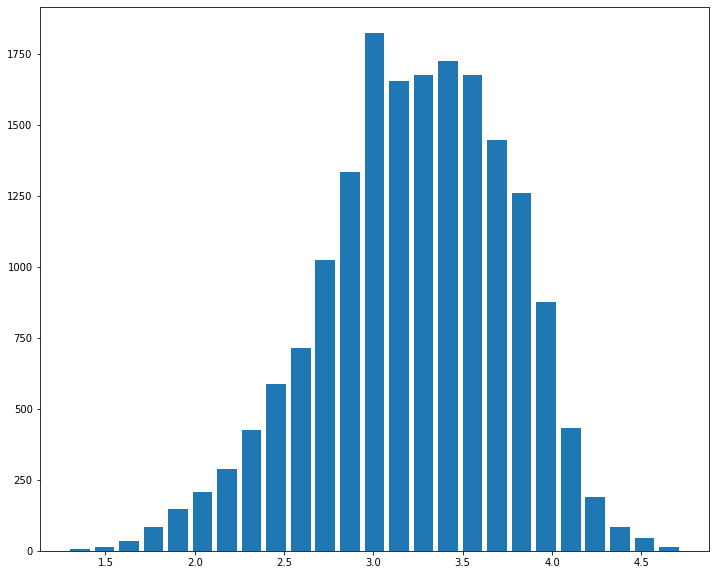

In [236]:
plt.hist(mean_ratings.sort_values(by='mean', ascending=False)['mean'].values, bins=25, rwidth=0.8)


In [257]:
data.size

100480507

In [258]:
row = movie_ratings['user'].values
col = movie_ratings['movie'].values
data = movie_ratings['rating'].values
from scipy.sparse import csr_matrix
csr_matrix((data, (row, col)), shape=(100480507, 100480507)).toarray()

MemoryError: Unable to allocate 35.9 PiB for an array with shape (100480507, 100480507) and data type int32

In [275]:
sorted_users = np.sort(movie_ratings['user'].unique())
sorted_movies = np.sort(movie_ratings['movie'].unique())
mean_normalization = []
for i in (range(sorted_movies.size)):
    for u in tqdm(range(sorted_users.size)):
        mean_normalization.append(movie_ratings[(movie_ratings['user'] == sorted_users[u]) & (movie_ratings['movie'] == sorted_movies[i])]['rating'].mean())
mean_normalization = np.array(mean_normalization)
mean_normalization


  0%|          | 24/480189 [00:06<36:13:29,  3.68it/s]


KeyboardInterrupt: 

In [ ]:
mean_normalization

<17770x2 sparse matrix of type '<class 'numpy.float64'>'
	with 35540 stored elements in Compressed Sparse Row format>

array([      6,       7,       8, ..., 2649421, 2649426, 2649429])